## Preprocessing: Data Cleaning & EDA

In [618]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import string
import re
import nltk

from tqdm import trange
from nltk import tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.probability import FreqDist
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import OneHotEncoder
import plotly.graph_objects as go
import plotly.express as px

In [619]:
df = pd.read_csv('data/renting.csv')

### 1. Removing NaN values, standardizing the text and removing the descriptions in English

Removing duplicated rows:

In [620]:
num_rows = df.shape[0]
df.drop_duplicates(inplace=True)
print(f'Dropped {num_rows - df.shape[0]} duplicate rows')

Dropped 2303 duplicate rows


Removing non-useful columns:

In [621]:
df.drop('Useful square meters', axis=1, inplace=True)
df.drop('Orientation', axis=1, inplace=True)
df.drop('Real state', axis=1, inplace=True)

In [622]:
print("Number of rows of the column 'Plot square meters' with NaN values: ", df['Plot square meters'].isna().sum())

Number of rows of the column 'Plot square meters' with NaN values:  8086


Plot square meters has a great number of NaN as it's only valuable for houses, not for apartments. Therefore, we'll fill with 0s the NaN values. This will also be useful to distinct between houses and apartments.

In [623]:
df['Plot square meters'].fillna(0, inplace=True)

Check what are the columns with the most NaN values:

In [624]:
df.isna().sum()

_id                       0
Title                     0
Description              96
Price                     0
Deposit                3672
Type                      1
Built square meters       0
Plot square meters        0
Rooms                     0
Bathrooms                 0
Storage room              0
Wardrobe                  0
Furnished                 0
Equipped kitchen          0
Renovation                0
Reduced mobility          0
Heating                   0
Garage                    0
Floor                   930
Elevator                  0
Air conditioning          0
Swimming pool             0
Garden                    0
Green areas               0
Terrace                   0
Consumption            4201
Emissions              4786
Location                  0
dtype: int64

Drop the row that has a NaN value in the column 'Type':

In [625]:
df.dropna(subset=['Type'], inplace=True)

Show a bar plot where each X axis value is a value from the 'Type' column and the Y axis is the number of samples that have NaN in the 'Floor' column:

<Axes: xlabel='Type'>

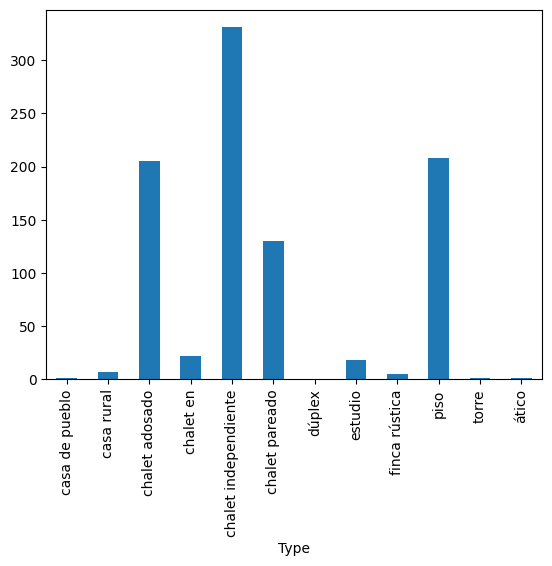

In [626]:
df['Floor'].isna().groupby(df['Type']).sum().plot(kind='bar')

Therefore, we will remove the rows that have NaN in the 'Floor' column and the value 'piso' in the 'Type' column:

In [627]:
df.drop(df[(df['Floor'].isna()) & (df['Type'] == 'piso')].index, inplace=True)

Now, we're sure that there are no apartments with NaN values in the 'Floor' column. So, for the rest of the NaN values in the 'Floor' column, we will replace them with the value 'no aplica':

In [628]:
df['Floor'].fillna('no aplica', inplace=True)

Print the number of rows where the columns 'Consumption' and 'Emissions' have NaN values at the same time:

In [629]:
# Print the number of rows where the columns 'Consumption' and 'Emissions' have NaN values at the same time
print("Number of rows with NaN values in the columns 'Consumption' and 'Emissions': ", df[(df['Consumption'].isna()) & (df['Emissions'].isna())].shape[0])

Number of rows with NaN values in the columns 'Consumption' and 'Emissions':  4152


Therefore, we will remove the columns 'Consumption' and 'Emissions':

In [630]:
df.drop('Consumption', axis=1, inplace=True)
df.drop('Emissions', axis=1, inplace=True)

Now, we're going to join the columns 'Title' and 'Description' into one column called 'Description' to avoid data sparsity:

In [631]:
df['Description'] = df.apply(lambda x: x['Title'] if pd.isna(x['Description']) else x['Title'] + '. ' + x['Description'], axis=1)
df.drop('Title', axis=1, inplace=True)

In order to standarize the data, we will make the 'Description' column lowercase and remove the punctuation:

In [632]:
superindex_to_normal = {
    '²': '2',
    '³': '3',
    '¹': '1',
    'º': 'o',
}

def replace_superindex(text):
    for superindex, normal in superindex_to_normal.items():
        text = text.replace(superindex, normal)
    return text

df['Description'] = df['Description'].apply(replace_superindex)

In [633]:
import pandas as pd
import re

# Assuming your DataFrame is named df and has a column 'Description'
# df = pd.DataFrame(...)  # Your actual DataFrame

# Function to transform the text in the 'Description' column
def transform_description(text):
    # Remove periods within numbers (e.g., '100.000' to '100000')
    text = re.sub(r'(\d+)\.(\d+)', r'\1\2', text)

    return text

# Apply the function to the 'Description' column
df['Description'] = df['Description'].apply(transform_description)

# Now the 'Description' column has the transformations applied

In [634]:
def clean_description(description, stopwords):
    # Remove punctuation

    # Create punctuation list adjusting to some spanish characters
    punctuation_extended = string.punctuation + "¡¿ºª“”…«»<>/\\-–—•·"

    description = "".join([char for char in description if char not in punctuation_extended])

    """With this, we manage to remove some of the spelling mistakes produced by writting numbers, currency symbols and other words together."""
    # Define the regular expression patterns for numbers and currency symbols
    number_pattern = r'\d+'
    currency_pattern = r'\€|\$'  # Add other currency symbols if needed

    # Split the description and process each word
    words = [' '.join(re.split(f'({number_pattern}|{currency_pattern})', word)) for word in description.split()]

    # Joining the processed words back into a string
    description = " ".join(words)

    # Remove stopwords
    description = " ".join([word for word in description.split() if word not in stopwords])

    return description

In [635]:
df['Description'] = df['Description'].str.lower()

# Load stopwords
with open('./stop-words.txt', 'r') as file:
    stopwords = file.read().splitlines()

# Apply the cleaning function to the Description column
df['Description'] = df['Description'].apply(lambda x: clean_description(x, stopwords))

Finally, we're going to convert the column 'Deposit' to a numeric column and fill the NaN values with 0s:

In [636]:
def extract_first_number(text):
    # If it's a NaN value or it's not a string, return 0
    if pd.isna(text) or not isinstance(text, str):
        return 0
    # Find all the numbers in the string
    matches = re.findall(r'\d+', text)
    # Return the first number found
    return int(matches[0]) if matches else 0

df['Deposit'] = df['Deposit'].apply(extract_first_number)


⚠️ **_id & Deposit will not be used to train the model, they'll be just used in the UI**

In [637]:
df.isna().sum()

_id                    0
Description            0
Price                  0
Deposit                0
Type                   0
Built square meters    0
Plot square meters     0
Rooms                  0
Bathrooms              0
Storage room           0
Wardrobe               0
Furnished              0
Equipped kitchen       0
Renovation             0
Reduced mobility       0
Heating                0
Garage                 0
Floor                  0
Elevator               0
Air conditioning       0
Swimming pool          0
Garden                 0
Green areas            0
Terrace                0
Location               0
dtype: int64

Based on the analysis of English comments throughout descriptions, there are just a few descriptions in English:

In [638]:
# english_keywords = ['and', 'is', 'are', 'was', 'were', 'be', 'been', 'has', 'have', 'will', 'shall']
english_keywords = ["available", "renting", "[eng]"]

# Create combinations of the keywords in lowercase, uppercase, and with punctuation
english_keywords = set(english_keywords + [word.lower() for word in english_keywords] + [word.upper() for word in english_keywords])
punctuated_keywords = set()
for punctuation in string.punctuation:
    for word in english_keywords:
        punctuated_keywords.update({punctuation + word, word + punctuation, punctuation + word + punctuation})

# Combine the original and punctuated keywords
english_keywords.update(punctuated_keywords)

def contains_english(text):
    text_words = {word.strip(string.punctuation).lower() for word in text.split()}
    return any(word in text_words for word in english_keywords)

df_english = df[df['Description'].apply(contains_english)]
df_english.to_csv('data/renting_english.csv', index=False)


In [639]:
print("Description 1:", df_english['Description'].iloc[0], sep='\n\n')
print("\nDescription 2:", df_english['Description'].iloc[1], sep='\n\n')

Description 1:

alquiler piso calle sombrerería 6 esp disponible noviembre reserve línea clic bajo mapa enlace adicional eng available from november book online by clicking on additional link under the map esp aceptan alquileres inferiores 4 meses eng rentals of less than 4 months are not accepted esp edad aceptada 24 35 eng age accepted 24 35 esp cómo funciona roomlessroomless plataforma online alquileres medialarga duración nace garantía inquilino comprobamos todos pisos fotos recientes fiables puedas reservar online tranquilidad evitar alguien haga tú reservar línea siga enlace aparece final página debajo mapa haga clic alquilar ahorasi necesita ayuda póngase contacto ayudaremoseng how does roomless workroomless is an online platform for mediumlong term rentals that was created as guarantee for the tenant we check all the apartments and the photos are recent and reliable so you can book online with peace of mind to avoid someone else doing it before youto book online follow the link

In [640]:
# remove the descriptions that contain English keywords
df = df[~df['Description'].apply(contains_english)]

### 2. Exploratory Data Analysis

Check what are the instances of the 'Type' column:

In [641]:
def plot_instances_of_home_per_type():
    type_counts = df['Type'].value_counts()

    fig = px.bar(type_counts, title='Quantity of Instances per Type of Home')
    fig.update_xaxes(type='category')
    fig.update_layout(
        xaxis_title="Tipo de Vivienda",
        yaxis_title="Cantidad de Instancias",
        xaxis=dict(
            title_font=dict(size=14),
            tickfont=dict(size=12),
        ),
        yaxis=dict(
            title_font=dict(size=14),
            tickfont=dict(size=12),
        ),
        title=dict(
            x=0.5,
            y=0.95,
            font=dict(
                family="Courier New, monospace",
                size=20,
                color="#7f7f7f"
            )
        )
    )
    fig.show()

In [642]:
plot_instances_of_home_per_type()

Therefore, we're going to check the number of instances of the types 'torre', 'casa de pueblo', 'finca rústica' & 'casa rural':

In [643]:
# Therefore, we're going to check the number of instances of the types 'torre', 'casa de pueblo', 'finca rústica', 'casa rural' & 'chalet en':
print("Number of instances of the type 'torre': ", df[df['Type'] == 'torre'].shape[0])
print("Number of instances of the type 'casa de pueblo': ", df[df['Type'] == 'casa de pueblo'].shape[0])
print("Number of instances of the type 'finca rústica': ", df[df['Type'] == 'finca rústica'].shape[0])
print("Number of instances of the type 'casa rural': ", df[df['Type'] == 'casa rural'].shape[0])
print("Number of instances of the type 'chalet en': ", df[df['Type'] == 'chalet en'].shape[0])

Number of instances of the type 'torre':  1
Number of instances of the type 'casa de pueblo':  1
Number of instances of the type 'finca rústica':  5
Number of instances of the type 'casa rural':  7
Number of instances of the type 'chalet en':  22


Therefore, we're going to remove the instances of the types 'torre', 'casa de pueblo', 'finca rústica', 'casa rural' & 'chalet en' in order to:
1. Have a more balanced dataset: the number of instances of the type 'piso' is 6232 times bigger than the number of instances of the type 'casa de pueblo'
2. Avoid non-common places to rent: 'torre', 'casa de pueblo', 'finca rústica', 'casa rural' & 'chalet en' are not common places to rent in Madrid

In [644]:
# Therefore, we're going to remove the instances of the types 'torre', 'casa de pueblo', 'finca rústica', 'casa rural' & 'chalet en'
df = df[~df['Type'].isin(['torre', 'casa de pueblo', 'finca rústica', 'casa rural', 'chalet en'])]

In [645]:
plot_instances_of_home_per_type()

#### Distribution of prices by Type of property

In [646]:
def histogram_of_prices():
    fig = px.histogram(df, x='Price', title='Histogram of the price of the houses')
    fig.show()

In [647]:
def show_the_price_per_type():
    fig = px.box(df, y='Type', x='Price', title='Distribution of prices by Type of property')
    fig.show()

In [648]:
histogram_of_prices()

In [649]:
show_the_price_per_type()

#### Heat Map of Corelation Between Attribtues
Eventhought theres no direct correlation between Plot Square Meters and Price, there could be Correlation if "Plot square meters is taken into account together with "Built square meters".

In [650]:
df_numeric = df.select_dtypes(include=[np.number])

corr = df_numeric.corr()

fig = go.Figure(data=go.Heatmap(
    z=corr,
    x=corr.columns,
    y=corr.columns,
    colorscale='Blues'
))
fig.show()

#### Scatterplot of Deposit with respect to Price
We can see that deposit does not correlate too much to the price

In [651]:
fig = px.scatter(df, y='Deposit', x='Price', title='Scatter Plot de Depósito vs Precio')

fig.update_layout(
    xaxis_title="Depósito",
    yaxis_title="Precio",
    xaxis=dict(
        title_font=dict(size=14),
        tickfont=dict(size=12),
    ),
    yaxis=dict(
        title_font=dict(size=14),
        tickfont=dict(size=12),
    ),
    title=dict(
        x=0.5,
        y=0.95,
        font=dict(
            family="Courier New, monospace",
            size=20,
            color="#7f7f7f"
        )
    )
)

fig.show()


#### Boxplot of Price by House Type
We can see that they all tend to have a similar box range. 
The range of prices boxes varies but we have to remember the difference of number of instances of the Type 

In [652]:
def boxplot_houses_per_type():
    fig = px.box(df, y='Type', x='Price', title='Distribución de Precios por Tipo de Casa')

    fig.update_layout(
        xaxis_title="Tipo de Casa",
        yaxis_title="Precio",
        xaxis=dict(
            title_font=dict(size=14),
            tickfont=dict(size=12),
        ),
        yaxis=dict(
            title_font=dict(size=14),
            tickfont=dict(size=12),
        ),
        title=dict(
            x=0.5,
            y=0.95,
            font=dict(
                family="Courier New, monospace",
                size=20,
                color="#7f7f7f"
            )
        )
    )
    fig.show()

In [653]:
boxplot_houses_per_type()

In [654]:
# compute how many instances of the dataset with type 'chalet independiente' have a price above 20000
df_high_ticket = df[(df['Type'] == 'chalet independiente') & (df['Price'] > 20000)]
print("Number of instances of the dataset with type 'chalet independiente' that have a price above 20000: ", df_high_ticket.shape[0])

# print df_high_ticket.head(7) but with just the prices
print("Prices of the instances of the dataset with type 'chalet independiente' that have a price above 20000: ", df_high_ticket['Price'].head(7).values)

Number of instances of the dataset with type 'chalet independiente' that have a price above 20000:  7
Prices of the instances of the dataset with type 'chalet independiente' that have a price above 20000:  [30000 25000 25000 25000 25000 25000 24000]


We'll assume two things:
1. The people who will use this tool won't be interested in renting a house with a price higher than 20.000€/month
2. As there are just 7 instances above 20.000€/month, they are not representative enough to train the model

In [655]:
df.drop(df[(df['Type'] == 'chalet independiente') & (df['Price'] > 20000)].index, inplace=True)

In [656]:
boxplot_houses_per_type()

### 3. Exporting the data

In [657]:
df.to_csv('data/preprocessed_data.csv', index=False)